In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import scipy 
import datetime
import json
from tqdm import tqdm
import threading

In [19]:
str(datetime.datetime.now())

'2024-08-16 02:21:19.845992'

In [14]:
L = 50
u = 0.0001
k1 = 1
k2 = 0.04
eps = 0.01  
alpha = 0.1
F0 = 1
m = 1
h = 0.1
eps2 = 0.007   

@njit 
def sum2(a):
    sh = a.shape[0]
    b =  np.zeros(sh)
    b[0] = a[0]
    for i in range(1,sh):
        b[i] = b[i-1] + a[i]

    return b


@njit
def f(x,v,t,l,alpha):
     k2= 1/(l-1)
     
     xIntoLeft = np.roll(x,-1)
     xIntoRight = np.roll(x,1)
     xIntoLeft[-1] = 0
     xIntoRight[0] = 0
     return np.where(v==0,
     np.where(np.abs(-x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t) < F0, -x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t ,F0*(1-eps) ),
     F0*(1-eps)/(1+alpha*np.abs(v)))


@njit
def acc(x,v,t,l,alpha):
    k2= 1/(l-1)
    xIntoLeft = np.roll(x,-1)
    xIntoRight = np.roll(x,1)
    xIntoLeft[-1] = 0
    xIntoRight[0] = 0

    return (-x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t - f(x,v,t,l,alpha) )/m



@njit
def tenstion(x,v,t,l,alpha):
    return m*acc(x,v,t,l,alpha) + f(x,v,t,l,alpha)


@njit
def step(x,v,t,l,alpha):
    k2= 1/(l-1)

    if np.all(v==0):
        t += (F0-np.max(tenstion(x,v,t,l,alpha)))/(k2*u)


        k_1 = v
        l_1 = acc(x,v,t,l,alpha)

        k_2 = v + l_1*h/2
        l_2 = acc(x+k_1*h/2,v + l_1*h/2,t + h/2,l,alpha)

        k_3 = v + l_2*h/2
        l_3 = acc(x+k_2*h/2,v + l_2*h/2,t + h/2,l,alpha)

        k_4 = v + l_3/2
        l_4 = acc(x+k_3*h,v + l_3*h, t + h,l,alpha)

        x = x +  (k_1 + 2*k_2 + 2*k_3 + k_4)*h/6
        v = v +  (l_1 + 2*l_2 + 2*l_3 + l_4)*h/6

        v = np.where(v<0, 0, v)
        

    else: 
        k_1 = v
        l_1 = acc(x,v,t,l,alpha)

        k_2 = v + l_1*h/2
        l_2 = acc(x+k_1*h/2,v + l_1*h/2,t + h/2,l,alpha)

        k_3 = v + l_2*h/2
        l_3 = acc(x+k_2*h/2,v + l_2*h/2,t + h/2,l,alpha)

        k_4 = v + l_3/2
        l_4 = acc(x+k_3*h,v + l_3*h, t + h,l,alpha)

        x = x +  (k_1 + 2*k_2 + 2*k_3 + k_4)*h/6
        v = v +  (l_1 + 2*l_2 + 2*l_3 + l_4)*h/6

        v = np.where(v<0, 0, v)

    return x, v,t+h

@njit(cache=True)
def np_any_axis1(x):
    """Numba compatible version of np.any(x, axis=1)."""
    out = np.zeros(x.shape[0], dtype=np.bool8)
    for i in range(x.shape[1]):
        out = np.logical_or(out, x[:, i])
    return out


@njit
def run(x,v,t,steps,l,alpha):
    xdata = np.zeros((steps,l),dtype=np.float64)
    vdata = np.zeros((steps,l),dtype=np.float64)
    tenstionData = np.zeros((steps,l),dtype=np.float64)
    for i in range(steps):
        x,v,t = step(x,v,t,l,alpha)
        xdata[i] = x
        vdata[i] = v
        tenstionData[i] = tenstion(x,v,t,l,alpha)

    slipping = np_any_axis1(vdata>0)

    slippingR = np.roll(slipping,+1)
    slippingL = np.roll(slipping,-1)

    slippingR[0] = False
    slippingL[-1] = False 

    ends  = np.logical_xor( slipping ,(slipping *slippingL))
    starts  = np.logical_xor( slipping ,(slipping *slippingR))

    totalX = np.sum(xdata,axis = 1)

    eventsSize = totalX[np.argwhere(ends)[:,0]] - totalX[np.argwhere(starts)[:,0]]
    eventsBlocks = np.sum(xdata[ends]!=xdata[starts],axis=1).reshape(-1,1)



    arr1 = vdata>0
    arr2 = arr1 > np.roll(arr1,1)
    arr3 = np.sum(arr2,axis=1)
    arr4 = sum2(arr3)

    arr5 = arr4[np.argwhere(starts)[:,0]]
    arr6 = arr4[np.argwhere(ends)[:,0]]

    eventsBlocks2 = arr6-arr5


    return x,v,t,eventsSize,eventsBlocks,eventsBlocks2,tenstionData,ends



@njit
def getData():

    x = 0.1*np.random.uniform(-1,1,L)
    v = np.zeros(L)
    t = 0


    # TsData 

    TsData= np.empty((0,50))
    eventsSizes = np.empty((0))
    eventsBlocks = np.empty((0)).astype(np.int64)

    for i in range(10):
        x,v,t,eventsSize,eventsBlock,eventsBlocks2,tenstionData,ends = run(x,v,t,100_000,L,alpha)


        # Ts = tenstionData[ends][np.argwhere(eventsBlocks2[:] >= 500)[:,0]]
        # TsData = np.concatenate((TsData,Ts),axis = 0)


        eventsSizes = np.concatenate((eventsSizes,eventsSize))
        eventsBlocks = np.concatenate((eventsBlocks,eventsBlock[:,0]))

        print(i)

    return  eventsSizes, eventsBlocks,TsData



In [5]:
def getHist(data , length):
    hist = np.zeros(length)
    for i in range(length):
        hist[i] = np.sum(data == i)
    
    return hist/data.shape[0]

# p_blocks_blocks_and_l

In [39]:
p_blocks_for_blocks_and_l = np.zeros((50,50)) 
for i in range(1,51):
    p_blocks_for_blocks_and_l[i-1] = getHist(np.loadtxt(f"dist_l={i}.txt"),50)

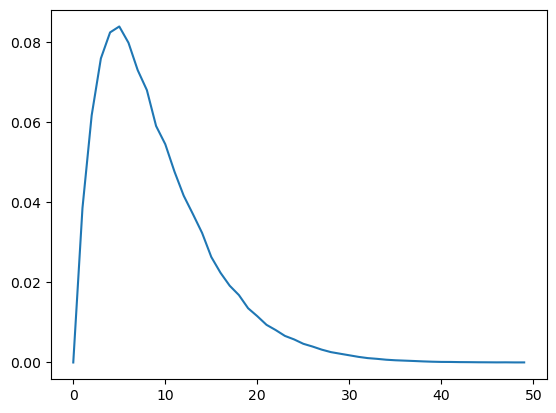

In [45]:
plt.plot(np.arange(L), p_blocks_for_blocks_and_l[49])

0
1
2
3
4
5
6
7
8
9


In [154]:
def function():
    eventsSizes, eventsBlocks,TsData = getData()
    np.save(f"TsDataAlpha={alpha},L={L}",TsData)
    np.save(f"EventsSizesAlpha={alpha},L={L}",eventsSizes)
    np.save(f"eventsBlocksAlpha={alpha},L={L}",eventsBlocks)
    print("completed")

In [155]:
function()

0
1
2
3
4
5
6
7
8
9
completed


In [159]:
from multiprocessing import Process

In [ ]:
if __name__ =="__main__":
    t0 = Process(target=function,args=())
    t1 = Process(target=function,args=())
    t2 = Process(target=function,args=())
    t3 = Process(target=function,args=())
    t4 = Process(target=function,args=())
    t5 = Process(target=function,args=())
    t6 = Process(target=function,args=())
    t7 = Process(target=function,args=())
    t8 = Process(target=function,args=())
    t9 = Process(target=function,args=())
    t10 = Process(target=function,args=())
    t11 = Process(target=function,args=())
    
    t0.start()
    t1.start()
    t2.start()
    t3.start()
    t4.start()
    t5.start()
    t6.start()
    t7.start()
    t8.start()
    t9.start()
    t10.start()
    t11.start()

    # t0.join()
    # t1.join()
    # t3.join()
    # t4.join()
    # t5.join()
    # t6.join()
    # t7.join()
    # t8.join()
    # t9.join()
    # t10.join()
    # t11.join()
    # t2.join()


0
00

0
0
0
0
0
0
0
00

1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
44

4
4
4
4
4
5
55

5
5
55

5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
77

77

7
7
7
7
7
7
7
7
8
88

8
8
8
88

8
8
88

9
completed9

completed
9
completed
9
completed
9
completed
9
completed
9
completed
9
completed
9
completed
9
completed
9
completed
9
completed


In [158]:
if __name__ =="__main__":
    t0 = Process(target=function,args=())
    t1 = threading.Thread(target=function,args=())
    t2 = threading.Thread(target=function,args=())
    t3 = threading.Thread(target=function,args=())
    t4 = threading.Thread(target=function,args=())
    t5 = threading.Thread(target=function,args=())
    t6 = threading.Thread(target=function,args=())
    t7 = threading.Thread(target=function,args=())
    t8 = threading.Thread(target=function,args=())
    t9 = threading.Thread(target=function,args=())
    t10 = threading.Thread(target=function,args=())
    t11 = threading.Thread(target=function,args=())
    
    t0.start()
    t1.start()
    t2.start()
    t3.start()
    t4.start()
    t5.start()
    t6.start()
    t7.start()
    t8.start()
    t9.start()
    t10.start()
    t11.start()

    t0.join()
    t1.join()
    t3.join()
    t4.join()
    t5.join()
    t6.join()
    t7.join()
    t8.join()
    t9.join()
    t10.join()
    t11.join()
    t2.join()


0
1
2
3
4
0
5
1
2
0
3
6
4
1
5
0
7
2
0
8
6
1
9
0
0
3
1
7
1
8
2
2
3
3
9
2
4
3
0
4
54
5
5

6
6
0
7
1
0
0
1
1
6
0
7
8
8
9
7
1
1
2
8
9
4
5
2
9
2
1
2
6
3
3
7
4
3
4
8
2
2
3
5
6
4
5
3
5
6
3
7
4
4
5
6
4
7
6
8
9
5
6
completed
completed
7
5
8
6
9
7
9
7
8
8
7
8
9
9
8
9
9
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed


In [135]:
import time 

In [136]:
time.sleep(2)

In [ ]:
# p_size_(size,blocks)

dists = []
distsMean = np.zeros(L)
distsVar = np.zeros(L)

for i in range(1,L+1):
    dists.append(eventsSizes[(eventsBlocks==i)[:,0]])
    distsMean[i-1] = np.mean(dists[i-1])
    distsVar[i-1] = np.var(dists[i-1])


# P_l_(l,t)


h = 0.001
minimum = np.min(TsData) - 10 *h
steps = np.round((1 - minimum)/h).astype(np.int64)
p_l_t_data = np.zeros((steps,L))

thersold_by_time = 1
for i in range(steps):
    is_above = TsData >= thersold_by_time 

    is_above_R = np.roll(is_above,+1,axis=1)
    is_above_L = np.roll(is_above,-1,axis=1)

    is_above_R[:,0] = False
    is_above_L[:,-1] = False 

    is_above_ends  = np.logical_xor( is_above ,(is_above *is_above_L))
    is_above_starts  = np.logical_xor( is_above ,(is_above * is_above_R))
    # lengths = np.argwhere(is_above_ends) - np.argwhere(is_above_starts) 
    lengths = np.nonzero(is_above_ends)[1] - np.nonzero(is_above_starts)[1]
    # p_l_t_data[i,lengths[:,0]] += 1

    for length in lengths:
        p_l_t_data[i,length] += 1

    thersold_by_time -= h

    print(i)


np.save(f"p_l_t_data={alpha},L={L}",p_l_t_data)




p_l_for_l_and_t = p_l_t_data/np.tile(np.sum(p_l_t_data,axis=1).reshape(-1,1),(1,50))



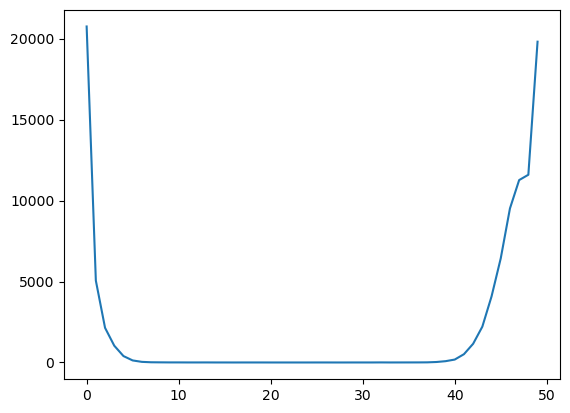

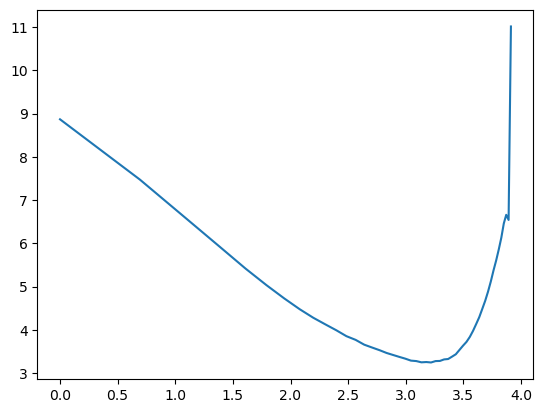

/tmp/ipykernel_35754/4105078570.py:12: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.arange(1,L+1)),np.log(p_l_t_data[step]))


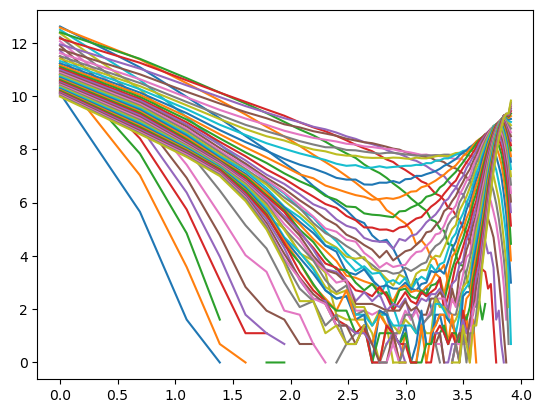

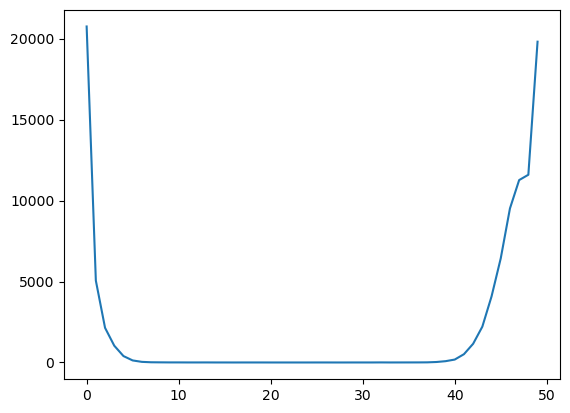

LinregressResult(slope=-0.5771786327627321, intercept=8.687499346161436, rvalue=-0.42620732569283876, pvalue=0.0020275216925630113, stderr=0.1768225084548407, intercept_stderr=0.5476661784709693)

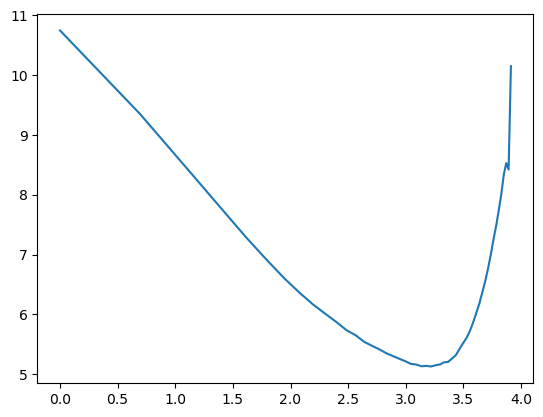

In [54]:
plt.plot(np.arange(L),p_l_t_data[50])
plt.show()

plt.plot(np.log(np.arange(1,L+1)),np.log(np.mean(p_l_t_data,axis=0)))
plt.show()

# print(scipy.stats.linregress(np.log(np.arange(1,L+1)),np.log(np.mean(p_l_t_data[:step],axis=0))))


for i in range(1,L):
    step = i
    plt.plot(np.log(np.arange(1,L+1)),np.log(p_l_t_data[step]))
plt.show()

step = 50
plt.plot(np.arange(L),p_l_t_data[step])
plt.show()
plt.plot(np.log(np.arange(1,L+1)),np.log(np.mean(p_l_t_data[:100],axis=0)))
scipy.stats.linregress(np.log(np.arange(1,L+1)),np.log(np.mean(p_l_t_data[:50],axis=0)))


In [12]:
for i in range(dists

array([], dtype=float64)

In [8]:
x_y = distsMean

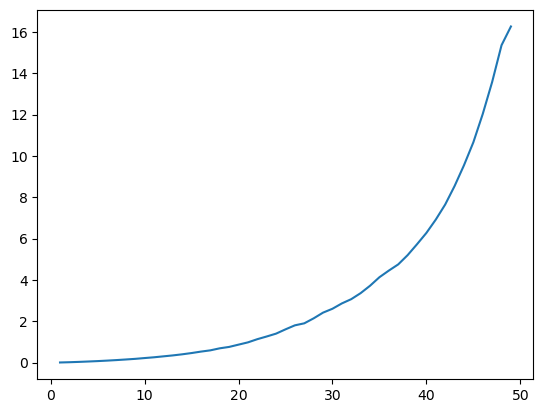

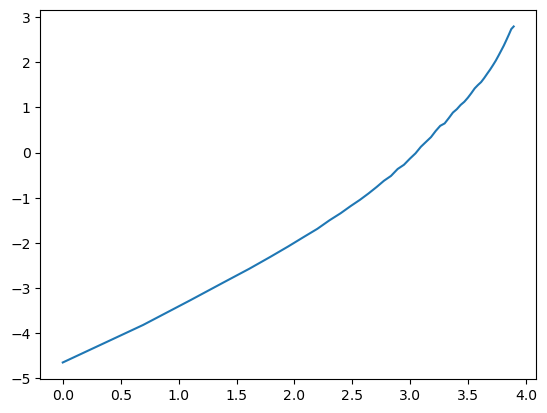

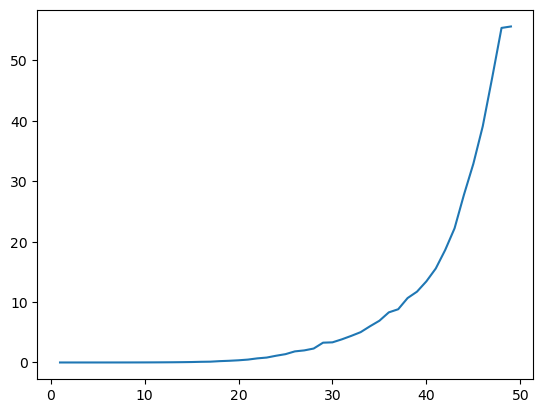

LinregressResult(slope=2.0232924667128023, intercept=-5.827420068199197, rvalue=0.9783066123027172, pvalue=8.69566331839037e-34, stderr=0.062494994892492405, intercept_stderr=0.1923841446745935)


In [6]:
plt.plot(np.arange(L),distsMean)
plt.show()

plt.plot(np.log(np.arange(1,L)),np.log(distsMean[1:]))
plt.show()

plt.plot(np.arange(L),distsVar)
plt.show()

print(scipy.stats.linregress(np.log(np.arange(1,L)),np.log(distsMean[1:])))

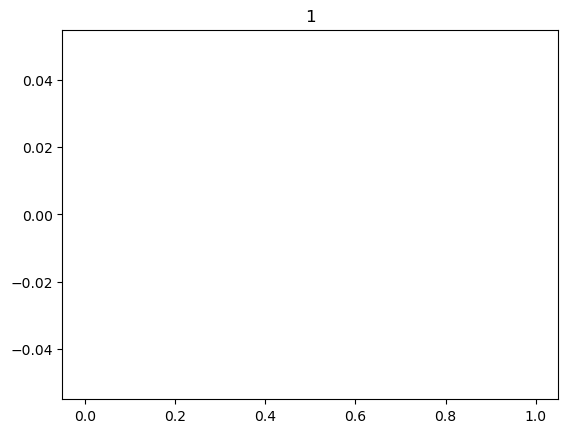

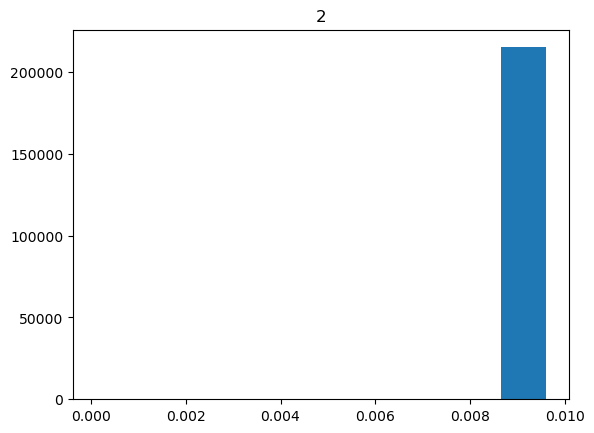

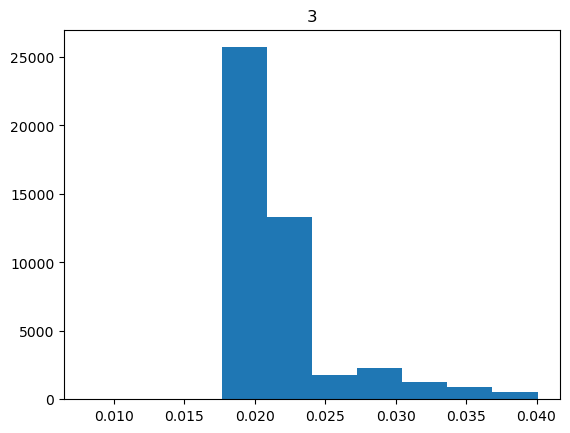

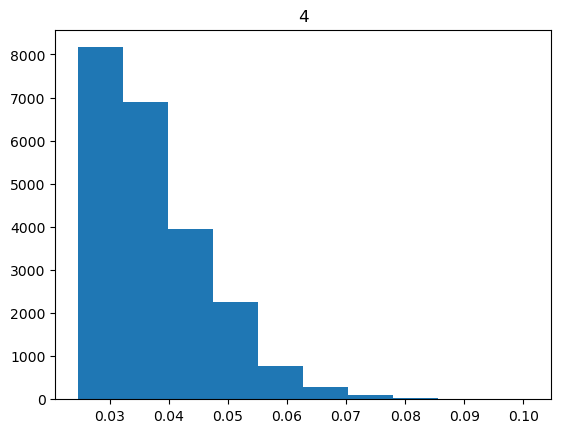

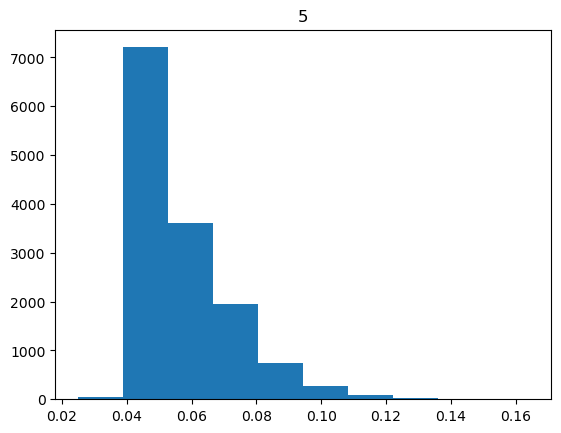

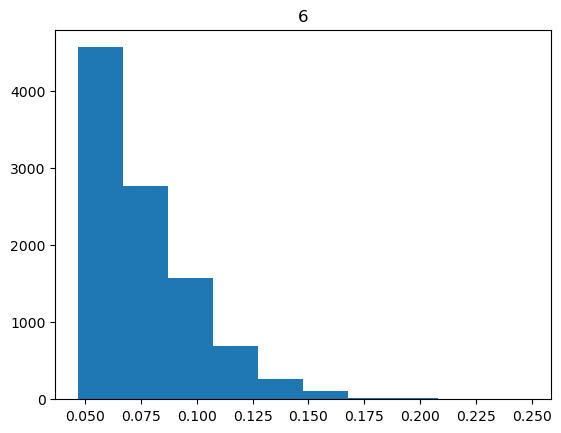

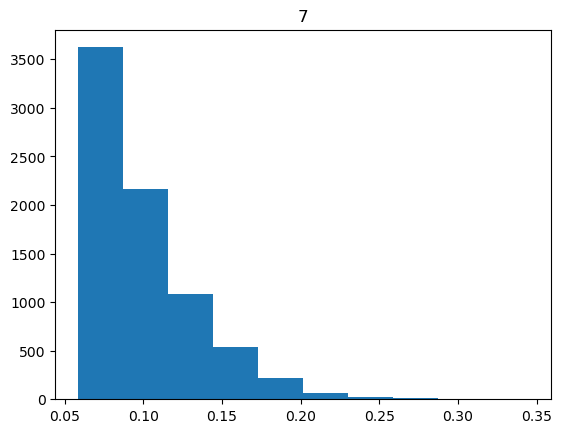

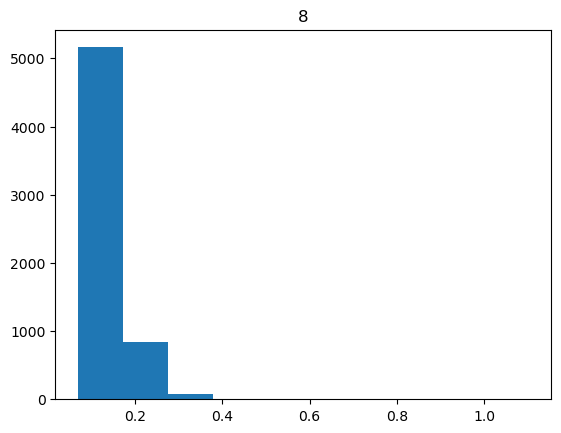

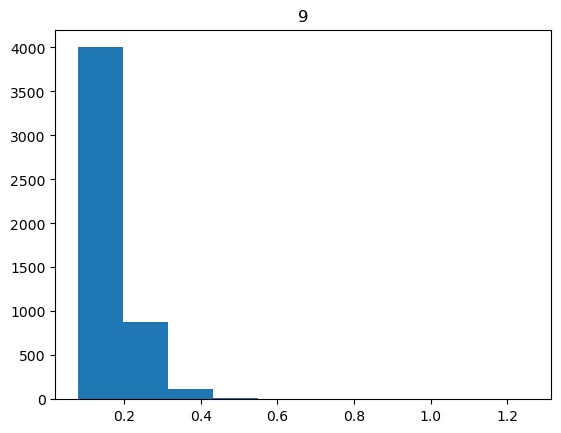

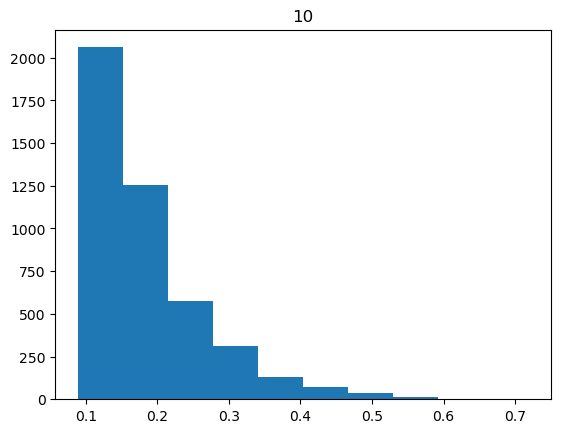

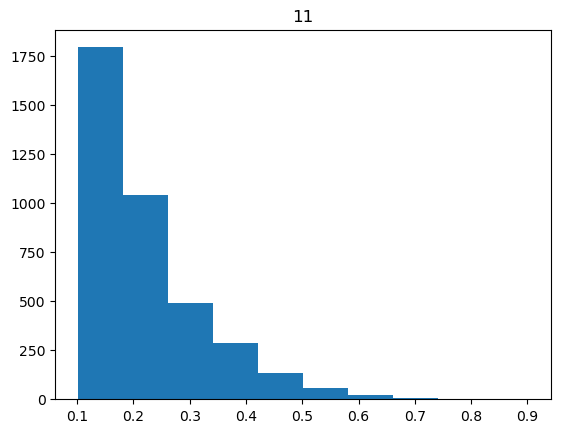

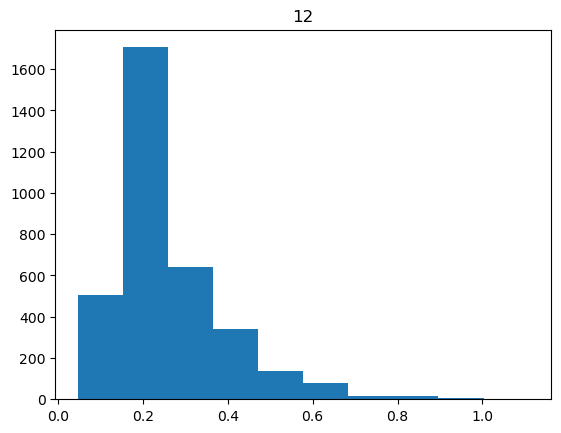

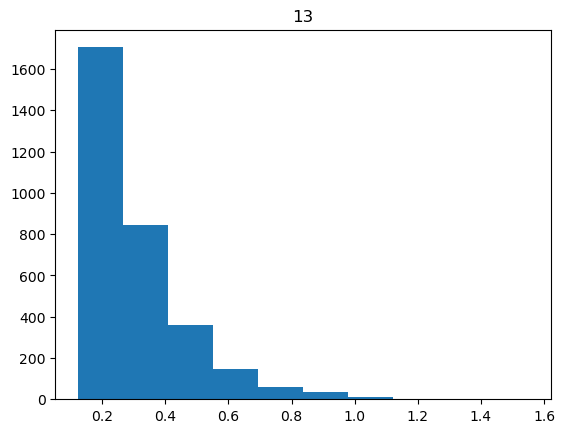

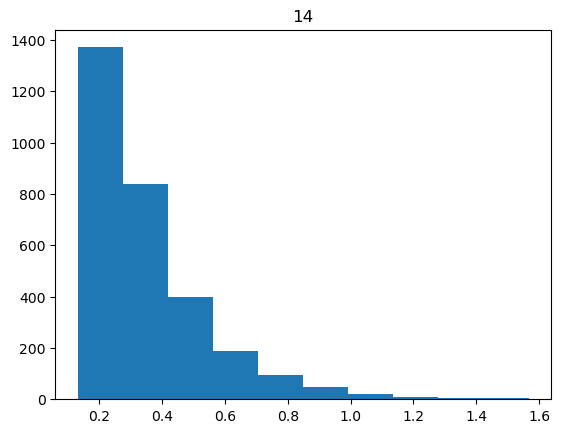

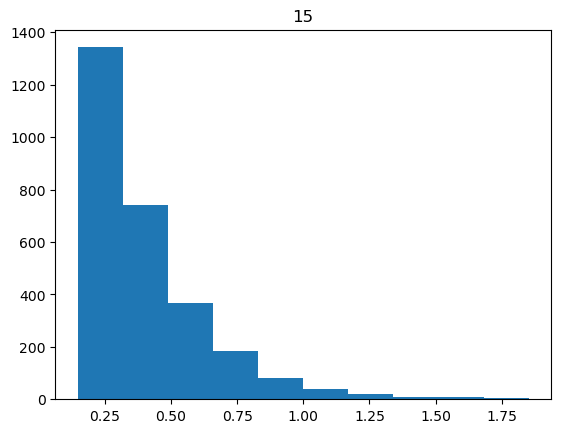

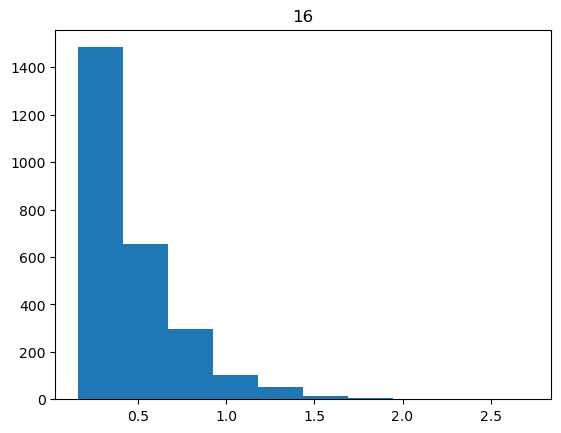

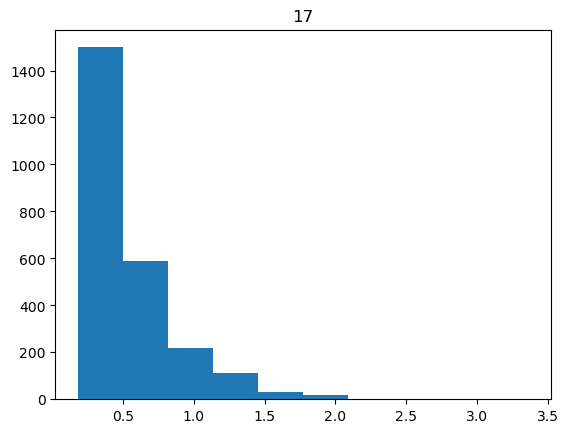

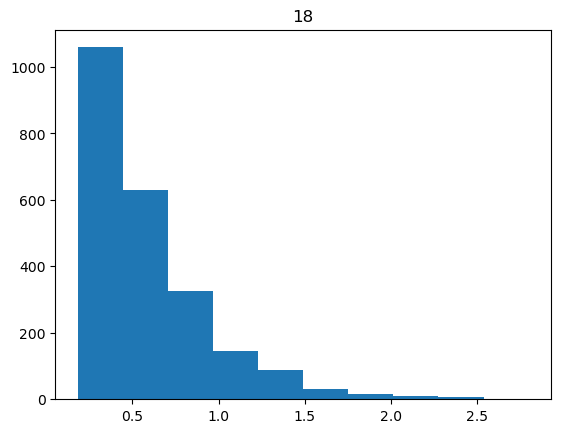

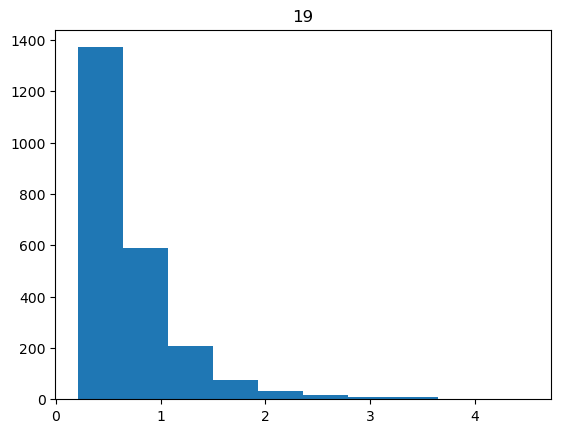

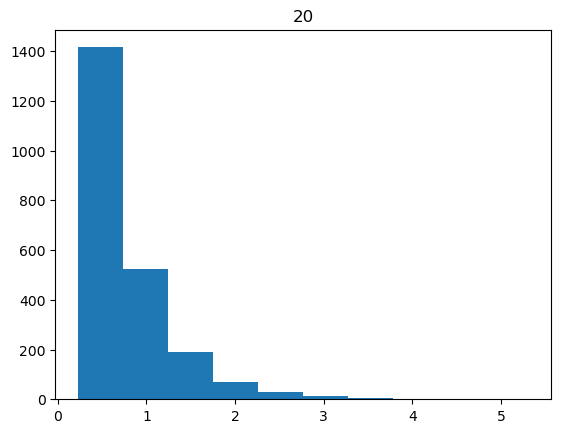

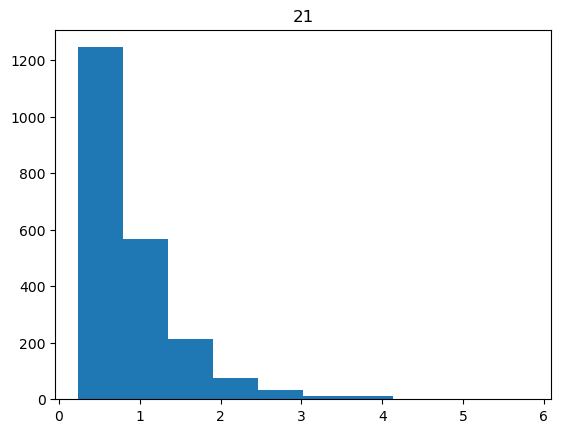

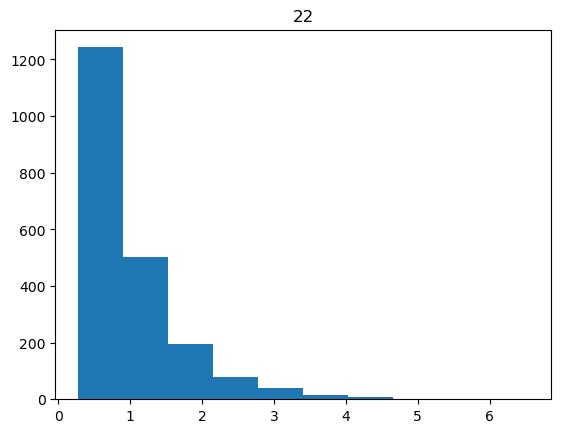

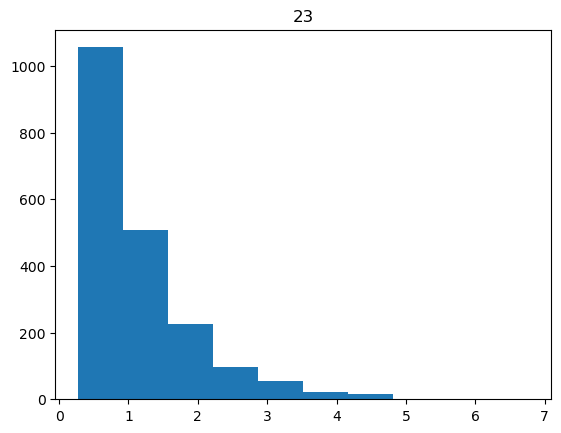

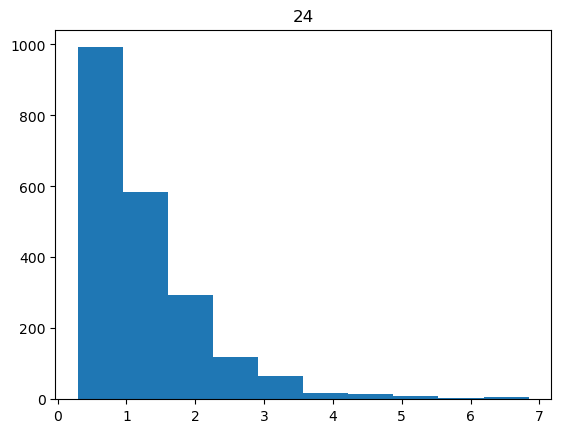

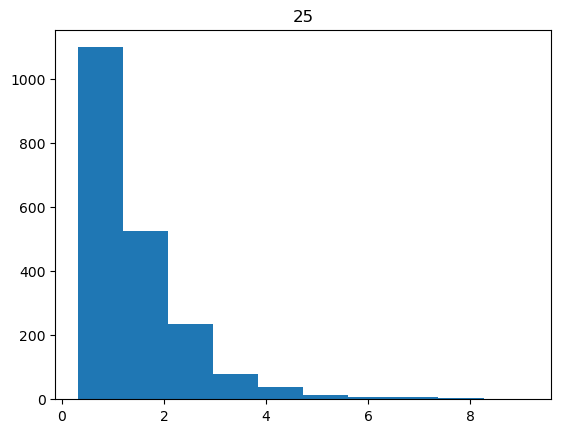

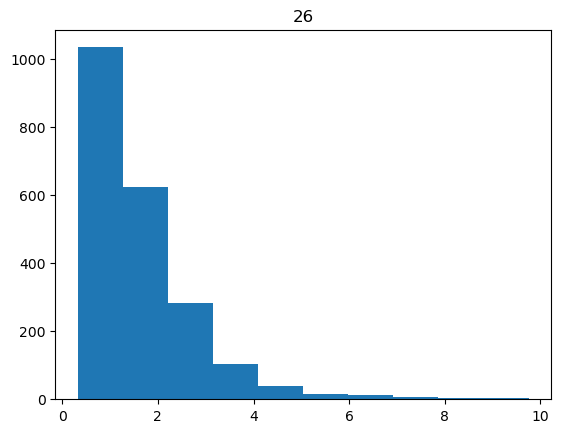

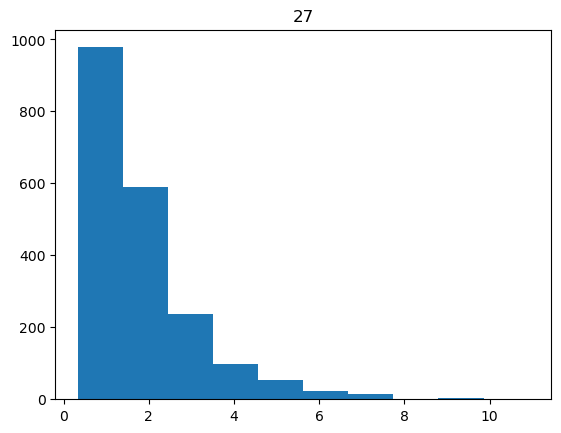

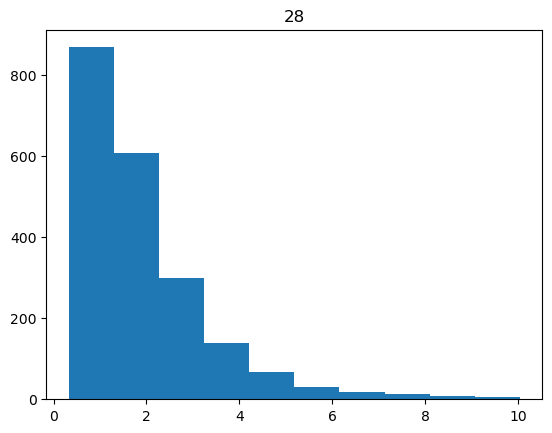

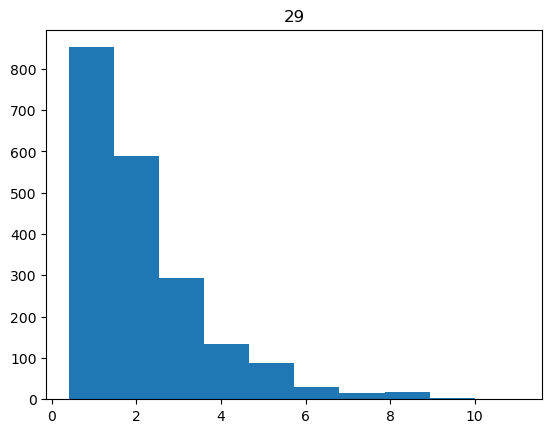

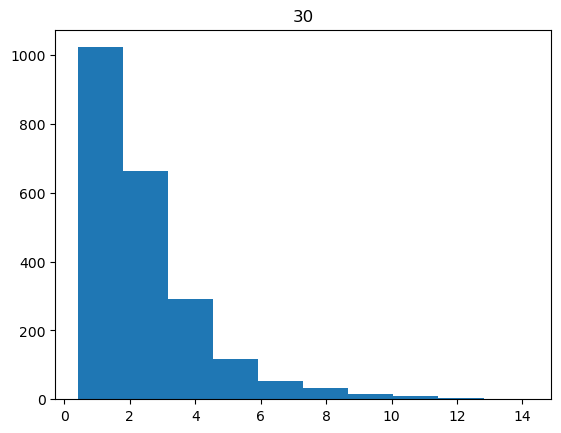

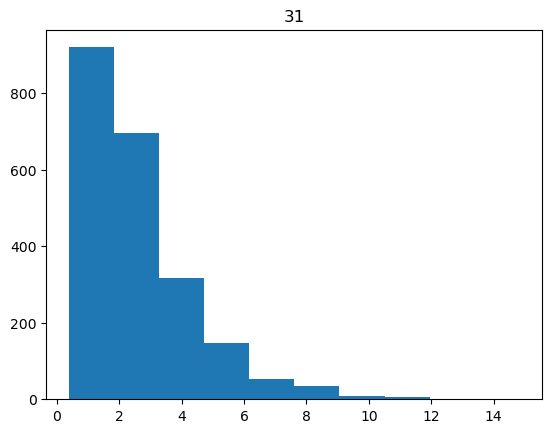

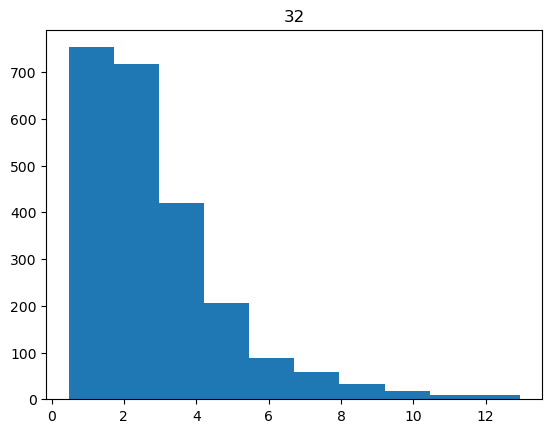

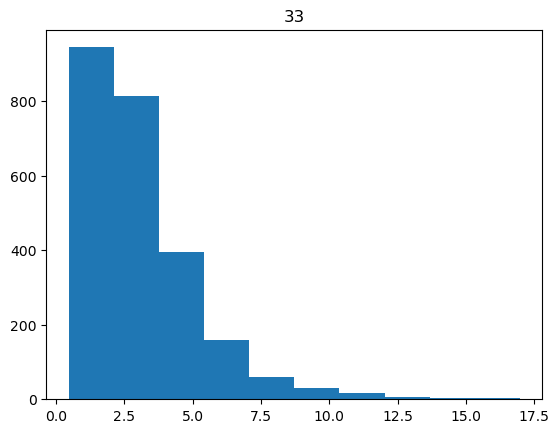

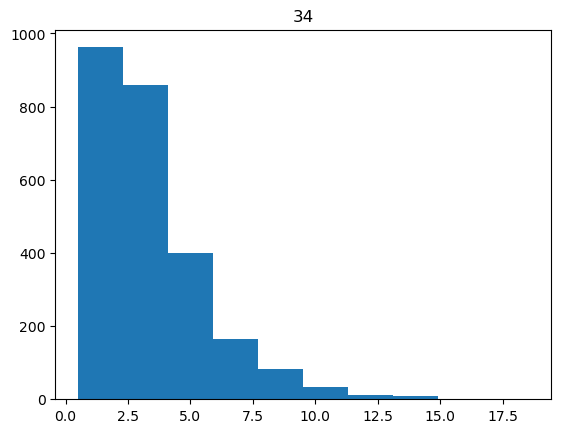

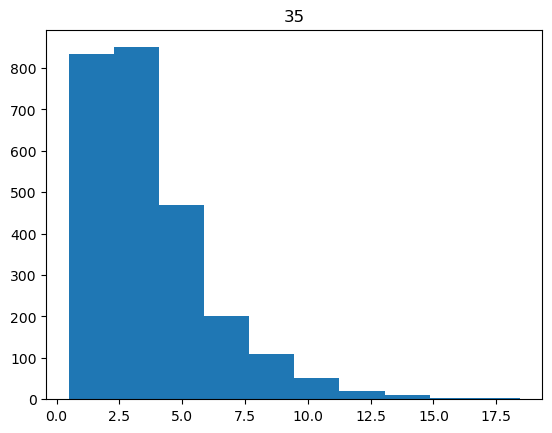

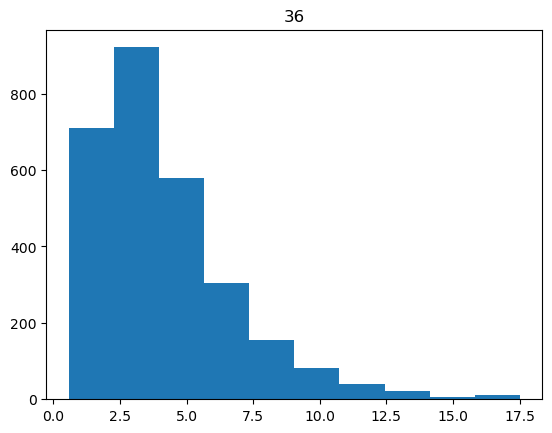

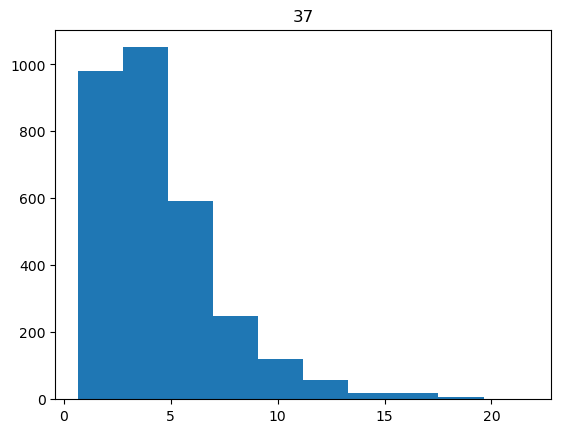

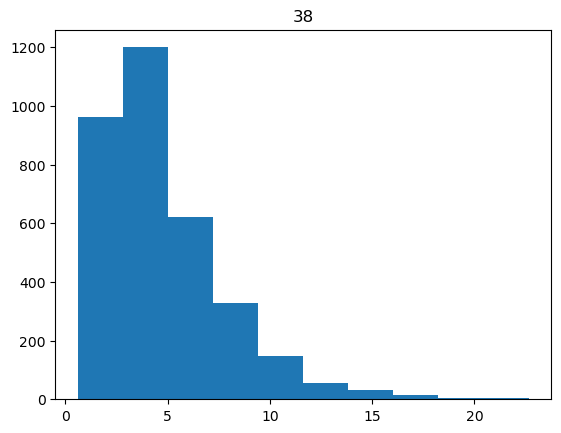

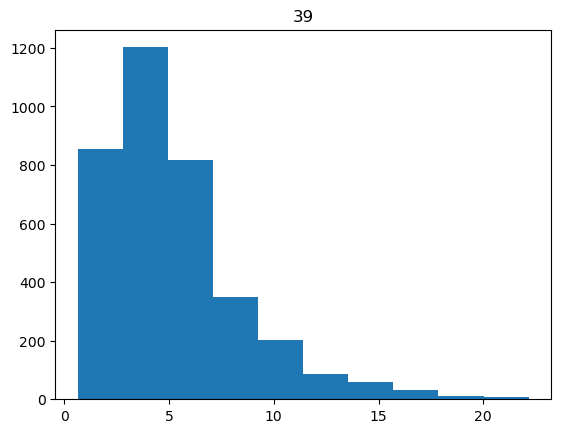

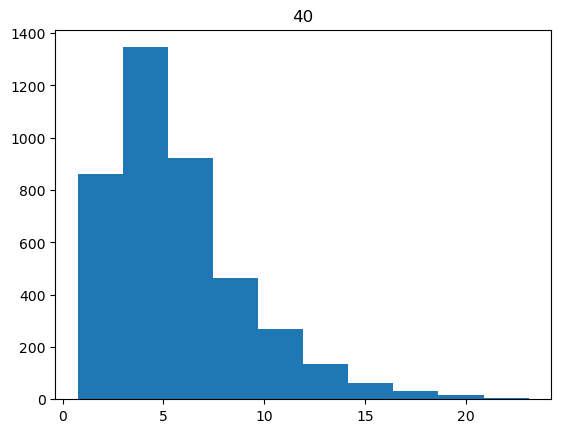

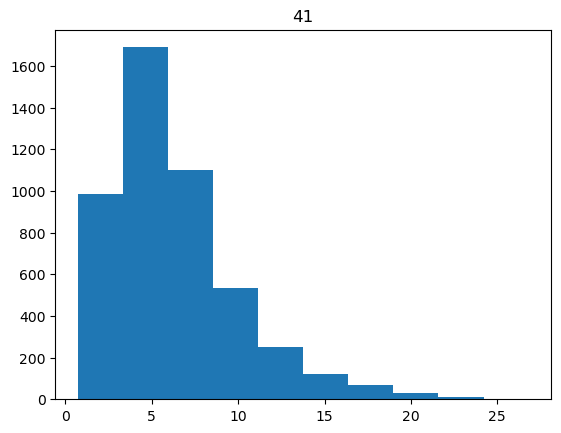

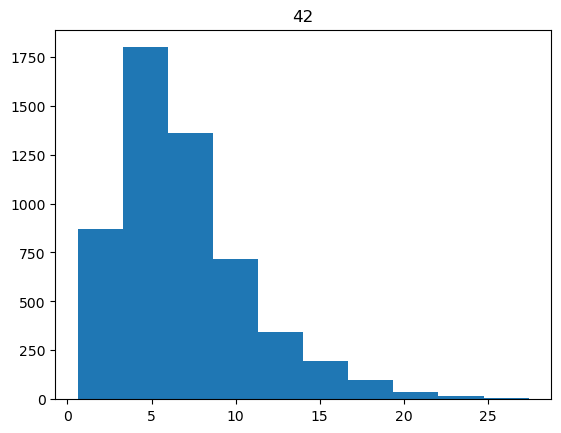

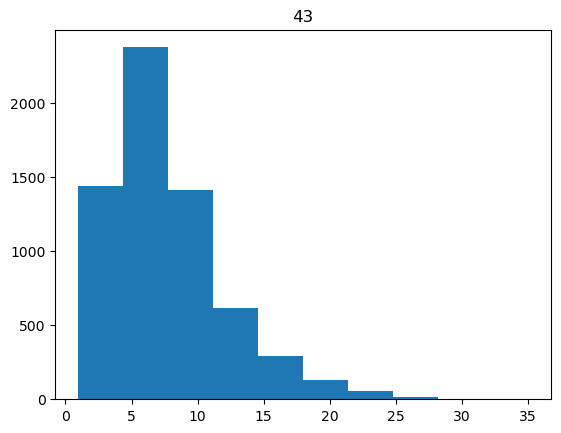

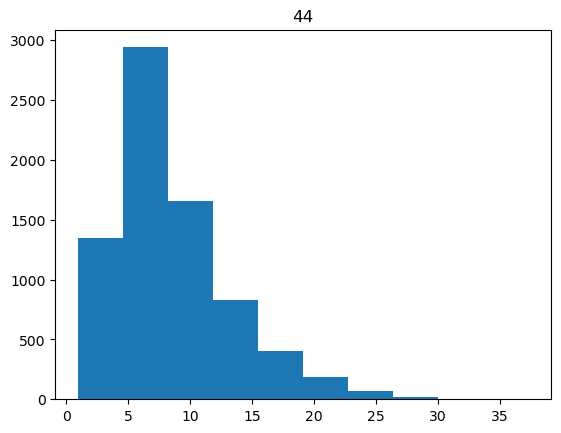

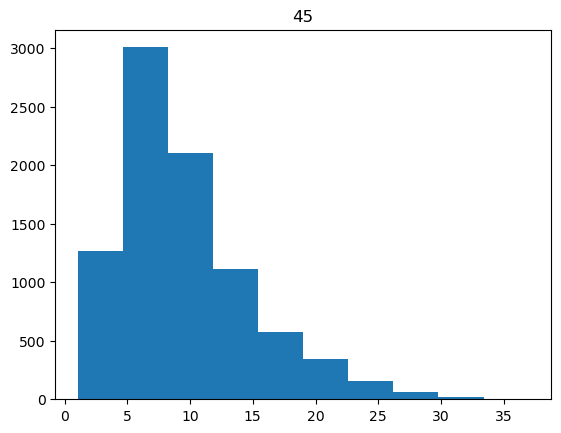

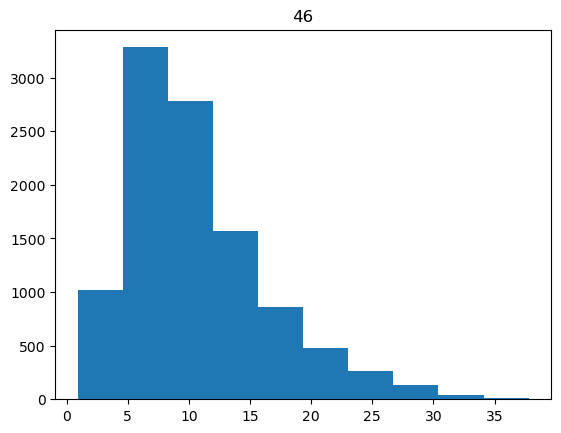

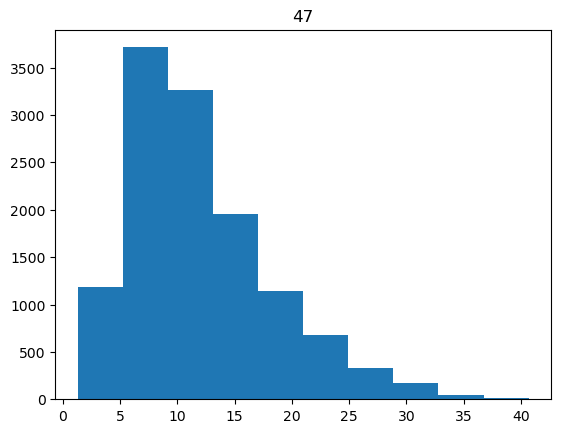

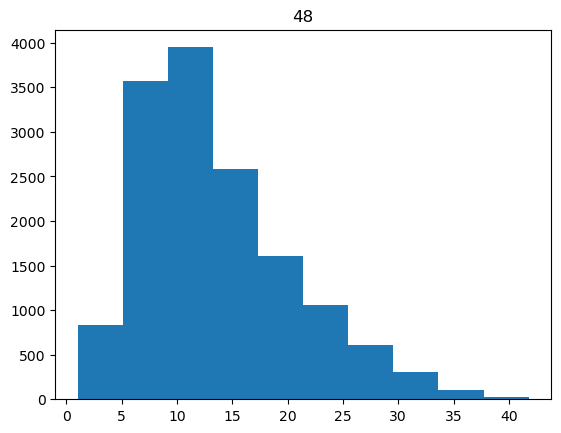

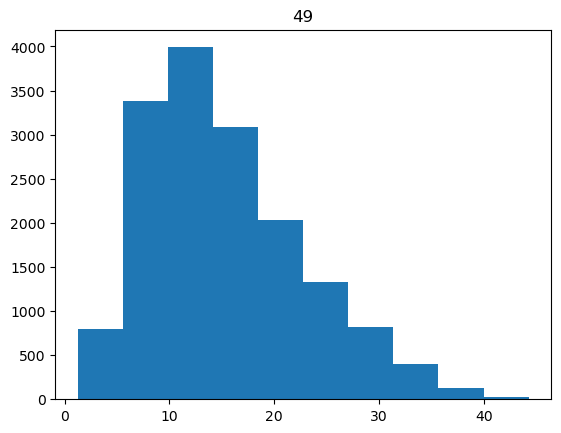

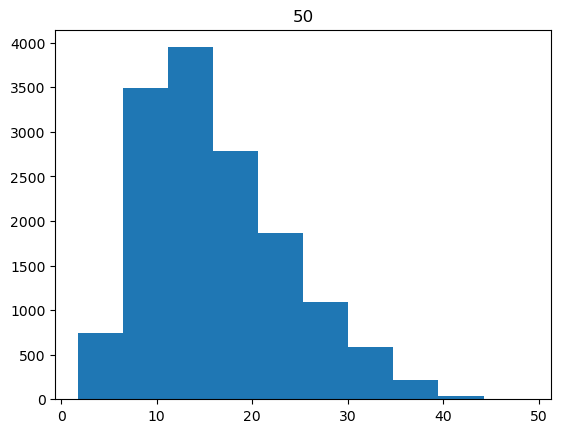

In [7]:
for i in range(0,L):
    plt.title(i+1)
    plt.hist(dists[i])
    plt.show()

# p_size_(size)

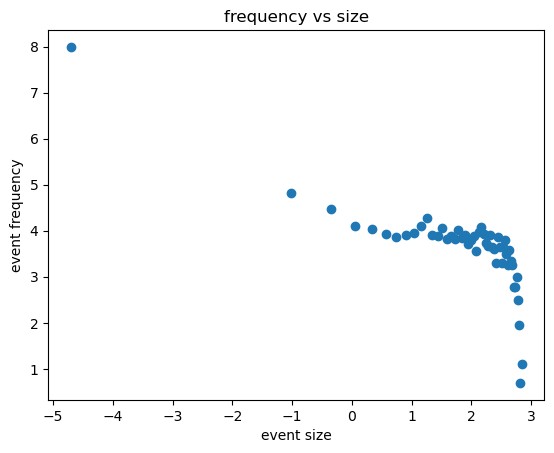

In [43]:
freq,size = np.histogram(eventsSize,bins=50)

#slope , intercept, rvalue ,_,_= scipy.stats.linregress(np.log(size[:-1]),np.log(freq))

plt.title("frequency vs size")
plt.xlabel("event size")
plt.ylabel("event frequency")
plt.scatter(np.log(size[:-1]),np.log(freq))
#plt.plot([np.log(size[0]),np.log(size[-2])],[intercept + slope.astype(np.float32)*np.log(size[0]), intercept + slope.astype(np.float32)*np.log(size[-2])])
#plt.text(-1,10,s = f"slope = {np.round(slope,3)}, intercept = {np.round(intercept,3)}, rval = {np.round(rvalue,3)}")
plt.savefig("plot.png")

In [33]:
np.max(eventsSizes)

120.2907664879458

In [34]:
np.logspace(np.log10(np.min(eventsSizes)),np.log10(np.max(eventsSizes)),50)

array([9.76586260e-03, 1.18356099e-02, 1.43440133e-02, 1.73840400e-02,
       2.10683608e-02, 2.55335254e-02, 3.09450234e-02, 3.75034180e-02,
       4.54517788e-02, 5.50846912e-02, 6.67591738e-02, 8.09079109e-02,
       9.80552885e-02, 1.18836829e-01, 1.44022747e-01, 1.74546492e-01,
       2.11539347e-01, 2.56372355e-01, 3.10707136e-01, 3.76557466e-01,
       4.56363914e-01, 5.53084300e-01, 6.70303312e-01, 8.12365366e-01,
       9.84535621e-01, 1.19319512e+00, 1.44607728e+00, 1.75255452e+00,
       2.12398562e+00, 2.57413669e+00, 3.11969143e+00, 3.78086938e+00,
       4.58217539e+00, 5.55330777e+00, 6.73025900e+00, 8.15664971e+00,
       9.88534534e+00, 1.19804155e+01, 1.45195085e+01, 1.75967291e+01,
       2.13261266e+01, 2.58459213e+01, 3.13236276e+01, 3.79622624e+01,
       4.60078693e+01, 5.57586377e+01, 6.75759546e+01, 8.18977977e+01,
       9.92549690e+01, 1.20290766e+02])

/tmp/ipykernel_150555/1402065044.py:4: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(size[:-1]),np.log(freq))


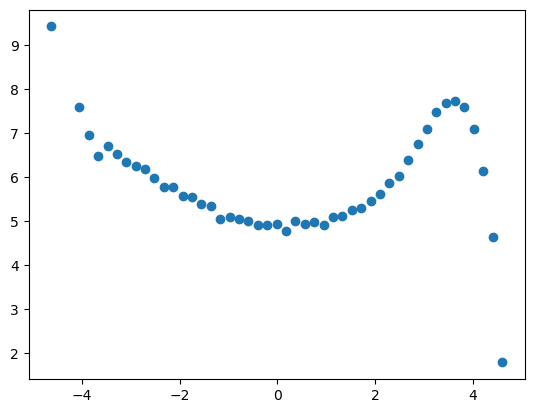

In [35]:
freq,size = np.histogram(eventsSizes,bins=np.logspace(np.log10(np.min(eventsSizes)),np.log10(np.max(eventsSizes)),50))


plt.scatter(np.log(size[:-1]),np.log(freq))


/tmp/ipykernel_150555/4235816754.py:8: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(size[:-1]),np.log(freq))


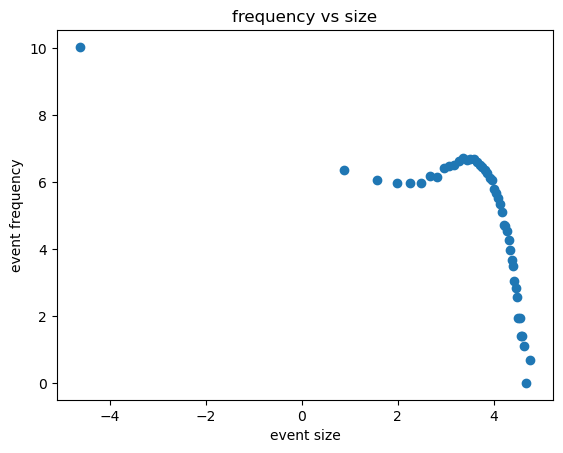

In [24]:
freq,size = np.histogram(eventsSizes,bins=50)

#slope , intercept, rvalue ,_,_= scipy.stats.linregress(np.log(size[:-1]),np.log(freq))

plt.title("frequency vs size")
plt.xlabel("event size")
plt.ylabel("event frequency")
plt.scatter(np.log(size[:-1]),np.log(freq))
#plt.plot([np.log(size[0]),np.log(size[-2])],[intercept + slope.astype(np.float32)*np.log(size[0]), intercept + slope.astype(np.float32)*np.log(size[-2])])
#plt.text(-1,10,s = f"slope = {np.round(slope,3)}, intercept = {np.round(intercept,3)}, rval = {np.round(rvalue,3)}")
plt.savefig("plot.png")

In [19]:
np.min(eventsSizes),np.max(eventsSizes)

(0.009765862603671849, 120.2907664879458)

In [23]:
np.log10(np.logspace(np.min(eventsSizes),np.max(eventsSizes),10))

array([9.76586260e-03, 1.33743215e+01, 2.67388771e+01, 4.01034327e+01,
       5.34679884e+01, 6.68325440e+01, 8.01970996e+01, 9.35616552e+01,
       1.06926211e+02, 1.20290766e+02])

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import scipy 
import datetime
import json
from tqdm import tqdm


# L = 50
# u = 0.01
# alpha = 0.1
# k1 = 1
# k2 = 0.01
# eps = 0.01  
# F0 = 1
# m = 1
# h = 0.1
  

L = 4000
u = 0.01
alpha = 3
k1 = 1
k2 = 0.04
eps = 0.01  
F0 = 1
m = 1
h = 0.1


@njit 
def sum2(a):
    sh = a.shape[0]
    b =  np.zeros(sh)
    b[0] = a[0]
    for i in range(1,sh):
        b[i] = b[i-1] + a[i]

    return b

@njit
def f(x,v,t,l,alpha):
     xIntoLeft = np.roll(x,-1)
     xIntoRight = np.roll(x,1)
     xIntoLeft[-1] = 0
     xIntoRight[0] = 0
     return np.where(v==0,
     np.where(np.abs(-x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t) < F0, -x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t ,F0*(1-eps) ),
     F0*(1-eps)/(1+alpha*np.abs(v)))


@njit
def acc(x,v,t,l,alpha):
    xIntoLeft = np.roll(x,-1)
    xIntoRight = np.roll(x,1)
    xIntoLeft[-1] = 0
    xIntoRight[0] = 0

    return (-x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t - f(x,v,t,l,alpha) )/m

@njit
def tenstion(x,v,t,l,alpha):
    return m*acc(x,v,t,l,alpha) + f(x,v,t,l,alpha)

@njit
def step(x,v,t,l,alpha):

    if np.all(v==0):
        t += (F0-np.max(tenstion(x,v,t,l,alpha)))/(k2*u)


        k_1 = v
        l_1 = acc(x,v,t,l,alpha)

        k_2 = v + l_1*h/2
        l_2 = acc(x+k_1*h/2,v + l_1*h/2,t + h/2,l,alpha)

        k_3 = v + l_2*h/2
        l_3 = acc(x+k_2*h/2,v + l_2*h/2,t + h/2,l,alpha)

        k_4 = v + l_3/2
        l_4 = acc(x+k_3*h,v + l_3*h, t + h,l,alpha)

        x = x +  (k_1 + 2*k_2 + 2*k_3 + k_4)*h/6
        v = v +  (l_1 + 2*l_2 + 2*l_3 + l_4)*h/6

        v = np.where(v<0, 0, v)
        

    else: 
        k_1 = v
        l_1 = acc(x,v,t,l,alpha)

        k_2 = v + l_1*h/2
        l_2 = acc(x+k_1*h/2,v + l_1*h/2,t + h/2,l,alpha)

        k_3 = v + l_2*h/2
        l_3 = acc(x+k_2*h/2,v + l_2*h/2,t + h/2,l,alpha)

        k_4 = v + l_3/2
        l_4 = acc(x+k_3*h,v + l_3*h, t + h,l,alpha)

        x = x +  (k_1 + 2*k_2 + 2*k_3 + k_4)*h/6
        v = v +  (l_1 + 2*l_2 + 2*l_3 + l_4)*h/6

        v = np.where(v<0, 0, v)

    return x, v,t+h

@njit(cache=True)
def np_any_axis1(x):
    """Numba compatible version of np.any(x, axis=1)."""
    out = np.zeros(x.shape[0], dtype=np.bool8)
    for i in range(x.shape[1]):
        out = np.logical_or(out, x[:, i])
    return out

@njit
def run(x,v,t,steps,l,alpha):
    xdata = np.zeros((steps,l),dtype=np.float64)
    vdata = np.zeros((steps,l),dtype=np.float64)
    tenstionData = np.zeros((steps,l),dtype=np.float64)
    for i in range(steps):
        x,v,t = step(x,v,t,l,alpha)
        xdata[i] = x
        vdata[i] = v
        tenstionData[i] = tenstion(x,v,t,l,alpha)

    slipping = np_any_axis1(vdata>0)
    slippingR = np.roll(slipping,+1)
    slippingL = np.roll(slipping,-1)
    slippingR[0] = False
    slippingL[-1] = False 
    ends  = np.logical_xor( slipping ,(slipping *slippingL))
    starts  = np.logical_xor( slipping ,(slipping *slippingR))
    totalX = np.sum(xdata,axis = 1)
    eventsSize = totalX[np.argwhere(ends)[:,0]] - totalX[np.argwhere(starts)[:,0]]
    return x,v,t,eventsSize 

@njit
def getData(iteration , steps ):
    x = 0.1*np.random.uniform(-1,1,L)
    v = np.zeros(L)
    t = 0
    eventsSizes = np.empty((0))

    for i in range(iteration):
        x,v,t,eventsSize = run(x,v,t,steps,L,alpha)
        eventsSizes = np.concatenate((eventsSizes,eventsSize))

    return  eventsSizes 


In [3]:

eventsSizes = getData(10,1_000_000)
# time = str(datetime.datetime.now())
# np.save(f"eventsSizes{time}",eventsSizes)


/tmp/ipykernel_150555/1035874884.py:138: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  x,v,t,eventsSize = run(x,v,t,steps,L,alpha)


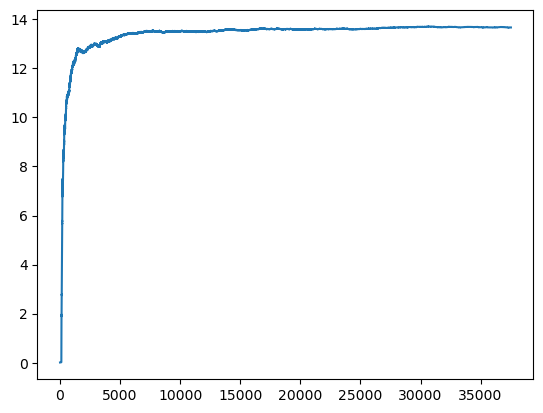

In [4]:
plt.plot(np.arange(1,eventsSizes.shape[0]+1) , np.cumsum(eventsSizes,axis = 0)/np.arange(1,eventsSizes.shape[0]+1) )

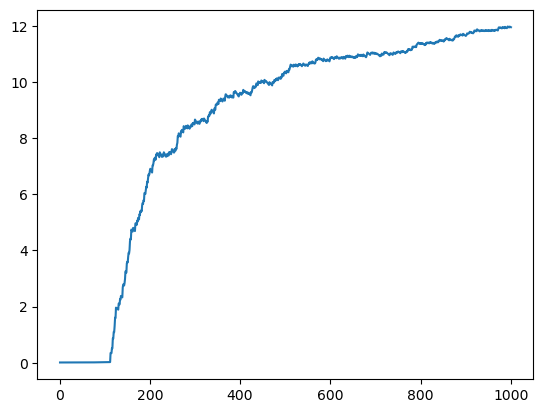

In [14]:
index = 1000
plt.plot(np.arange(1,index+1) , np.cumsum(eventsSizes[:index],axis = 0)/np.arange(1,index+1) )

In [5]:
eventsSizes.shape

(37524,)

/tmp/ipykernel_150555/4272765159.py:4: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(p1[1][:-1]),np.log(p1[0]))


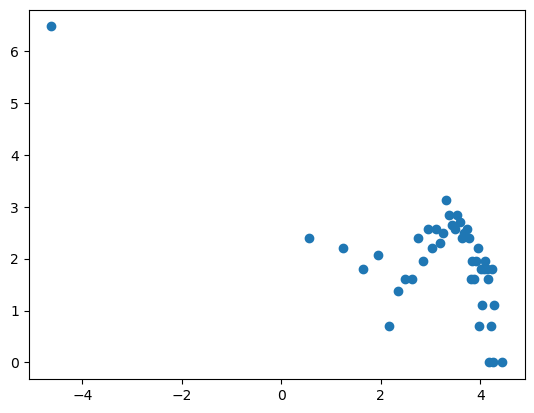

/tmp/ipykernel_150555/4272765159.py:7: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(p2[1][:-1]),np.log(p2[0]))


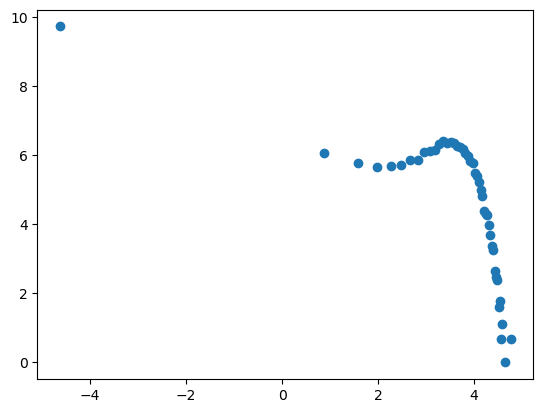

/tmp/ipykernel_150555/4272765159.py:13: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(p3[1][:-1]),np.log(p3[0]))


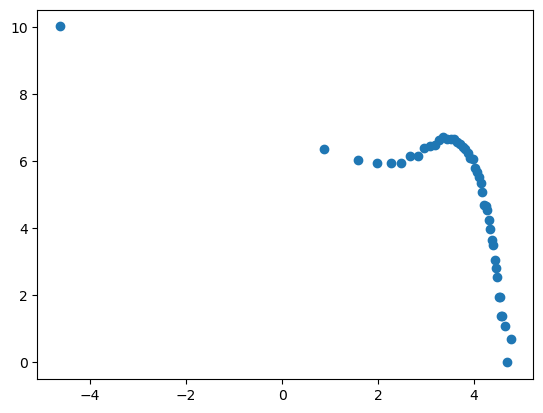

In [17]:
p1 = np.histogram(eventsSizes[:1000],bins = 50)
p2 = np.histogram(eventsSizes[10000:], bins = 50 )

plt.scatter(np.log(p1[1][:-1]),np.log(p1[0]))
plt.show()

plt.scatter(np.log(p2[1][:-1]),np.log(p2[0]))
plt.show()


p3 = np.histogram(eventsSizes[:], bins = 50)

plt.scatter(np.log(p3[1][:-1]),np.log(p3[0]))
plt.show()


In [33]:
eventsSizes.shape

(36938,)

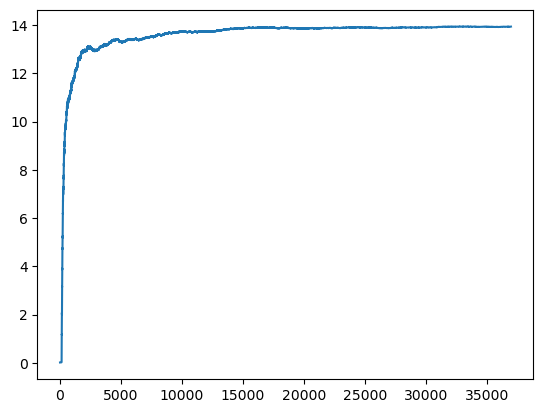

In [32]:
plt.plot(np.arange(1,eventsSizes.shape[0] + 1 ), np.cumsum(eventsSizes,axis = 0) / np.arange(1,eventsSizes.shape[0] + 1 ))
# plt.xlim((0,5000))

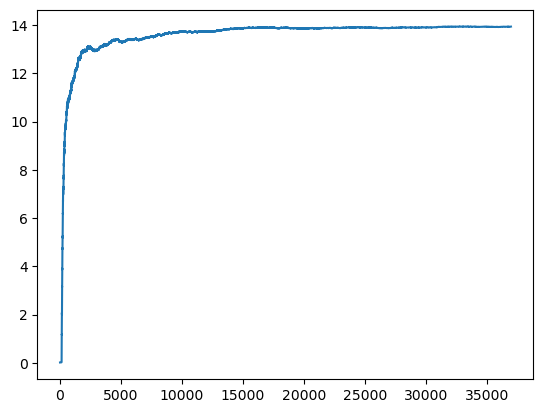

In [13]:
plt.plot(np.arange(1,eventsSizes.shape[0] + 1 ), np.cumsum(eventsSizes,axis = 0) / np.arange(1,eventsSizes.shape[0] + 1 ))

In [ ]:

index = 2
freq,size = np.histogram(eventsSizes,bins=20)

plt.scatter(np.log(size[:-1]),np.log(freq))

In [17]:
eventsSizes.shape

(3935,)

/tmp/ipykernel_10878/2432290825.py:4: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(size[:-1]),np.log(freq))


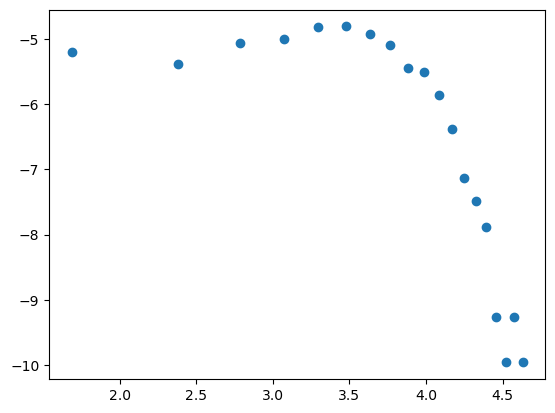

In [16]:
index = 2
freq,size = np.histogram(eventsSizes,bins=20,density=True)

plt.scatter(np.log(size[:-1]),np.log(freq))

In [5]:
np.save

<function numpy.save(file, arr, allow_pickle=True, fix_imports=True)>

/tmp/ipykernel_10878/3054262935.py:3: RuntimeWarning: invalid value encountered in log
  slope , intercept, rvalue ,_,_= scipy.stats.linregress(np.log(size[:index]),np.log(freq[:index]))
/tmp/ipykernel_10878/3054262935.py:7: RuntimeWarning: invalid value encountered in log
  plt.scatter(np.log(size[:-1]),np.log(freq))
/tmp/ipykernel_10878/3054262935.py:8: RuntimeWarning: invalid value encountered in log
  plt.plot([np.log(size[0]),np.log(size[index])],[intercept + slope.astype(np.float32)*np.log(size[0]), intercept + slope.astype(np.float32)*np.log(size[index])])


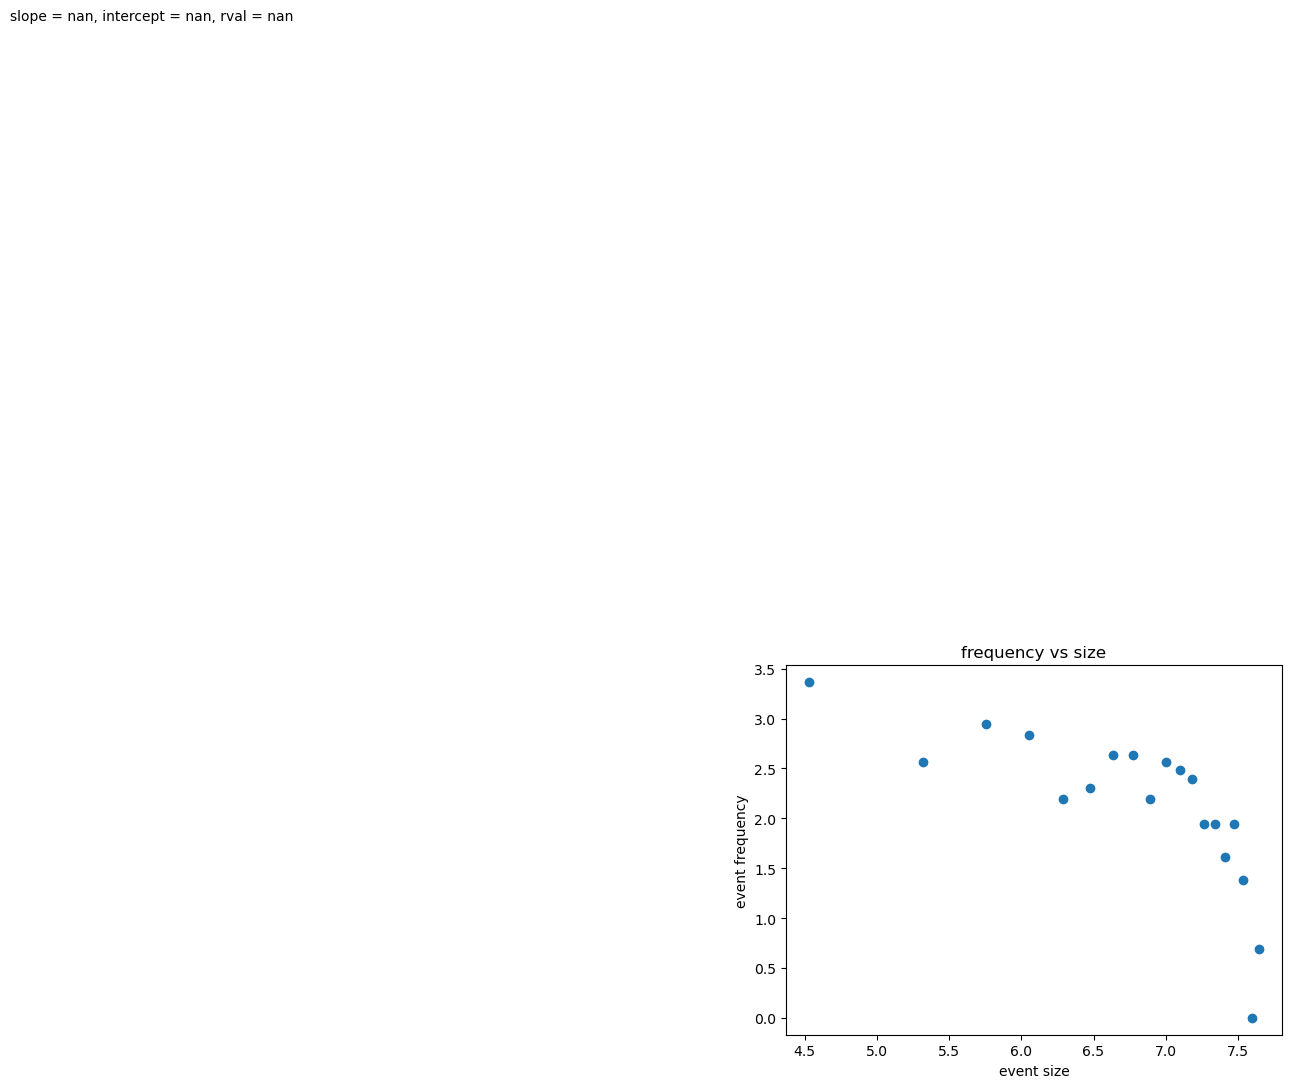

In [5]:
index = 2
freq,size = np.histogram(eventsSizes,bins=20)
slope , intercept, rvalue ,_,_= scipy.stats.linregress(np.log(size[:index]),np.log(freq[:index]))
plt.title("frequency vs size")
plt.xlabel("event size")
plt.ylabel("event frequency")
plt.scatter(np.log(size[:-1]),np.log(freq))
plt.plot([np.log(size[0]),np.log(size[index])],[intercept + slope.astype(np.float32)*np.log(size[0]), intercept + slope.astype(np.float32)*np.log(size[index])])
plt.text(-1,10,s = f"slope = {np.round(slope,3)}, intercept = {np.round(intercept,3)}, rval = {np.round(rvalue,3)}")
plt.savefig("plot.png")

In [7]:
np.load("eventsSizes2024-10-01 23:49:52.714525.npy").shape

(1544,)

In [14]:
freq

array([155,   4,   0,   5,  14,   5,   7,   5,   4,  16,   7,   5,   5,
         9,   2,   0,   2,   3,   1,   1])

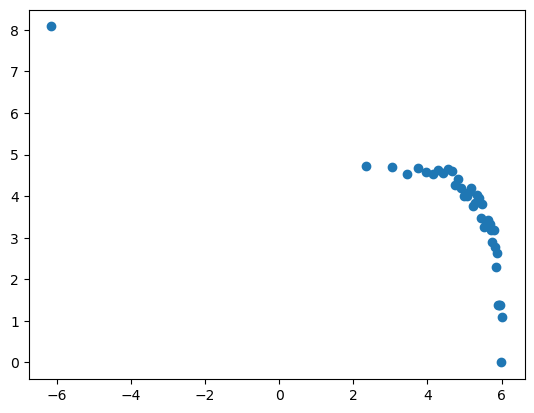

In [12]:

index = 2
freq,size = np.histogram(eventsSizes,bins=40)

plt.scatter(np.log(size[:-1]),np.log(freq))